In [1]:
# 1) IMPORT LIBRARIES
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
import math
import warnings

warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# 2) DATA PREPARATION
def fetch_stock_data(symbol='AAPL', period='2y'):
    df = yf.download(symbol, period=period)
    # Tính toán Features
    df['Returns'] = df['Close'].pct_change()
    df['RSI'] = 100 - (100 / (1 + (df['Close'].diff().where(df['Close'].diff() > 0, 0).rolling(14).mean() /
                                  -df['Close'].diff().where(df['Close'].diff() < 0, 0).rolling(14).mean())))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['BB_Upper'] = df['Close'].rolling(20).mean() + 2*df['Close'].rolling(20).std()
    df['BB_Lower'] = df['Close'].rolling(20).mean() - 2*df['Close'].rolling(20).std()
    df['Volatility'] = df['Returns'].rolling(20).std()
    df['MA_20'] = df['Close'].rolling(20).mean()
    df['MA_50'] = df['Close'].rolling(50).mean()
    return df.dropna()

symbol = 'AAPL'
df = fetch_stock_data(symbol)
features = ['Close', 'Volume', 'Returns', 'RSI', 'MACD', 'BB_Upper', 'BB_Lower', 'Volatility', 'MA_20', 'MA_50']
data = df[features].values

# Scaling và Windowing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0]) # Dự báo Close Price
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)
split = int(0.8 * len(X))
train_loader = DataLoader(TensorDataset(torch.from_numpy(X[:split]).float(), torch.from_numpy(y[:split]).float()), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(X[split:]).float(), torch.from_numpy(y[split:]).float()), batch_size=32, shuffle=False)

[*********************100%***********************]  1 of 1 completed


In [3]:
# 3) MODEL ARCHITECTURE
class CausalDiscoveryLayer(nn.Module):
    def __init__(self, num_vars):
        super().__init__()
        self.causal_logits = nn.Parameter(torch.randn(num_vars, num_vars) * 0.01)

    def get_causal_adjacency(self, temperature=0.5, hard=False):
        adj = torch.sigmoid(self.causal_logits / temperature)
        eye = torch.eye(adj.size(0)).to(adj.device)
        adj = adj * (1 - eye) # Loại bỏ self-loop
        if hard: return (adj > 0.5).float()
        return adj

class CDTransformer(nn.Module):
    def __init__(self, num_vars, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.causal_discovery = CausalDiscoveryLayer(num_vars)
        self.input_proj = nn.Linear(num_vars, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        adj = self.causal_discovery.get_causal_adjacency()
        # Áp dụng causal guidance vào feature (nhân ma trận đặc trưng với ma trận nhân quả)
        # x shape: [Batch, Seq, Vars]
        causal_x = torch.matmul(x, adj)
        combined_x = self.input_proj(x + 0.1 * causal_x)
        x_trans = self.transformer(combined_x)
        out = self.fc_out(x_trans[:, -1, :])
        return out, adj, x_trans

model = CDTransformer(num_vars=len(features)).to(device)

In [4]:
# 4) TRAINING LOOP
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
epochs = 50
history = {'loss': [], 'lr': []}

print("Starting training...")
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
        preds, adj, _ = model(xb)

        # Loss = Prediction Loss + Sparsity Penalty (khuyến khích ma trận nhân quả thưa)
        loss = criterion(preds, yb) + 0.01 * torch.norm(adj, 1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    history['loss'].append(avg_loss)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

Starting training...
Epoch 10/50 - Loss: 0.4435
Epoch 20/50 - Loss: 0.3807
Epoch 30/50 - Loss: 0.3327
Epoch 40/50 - Loss: 0.2886
Epoch 50/50 - Loss: 0.2546


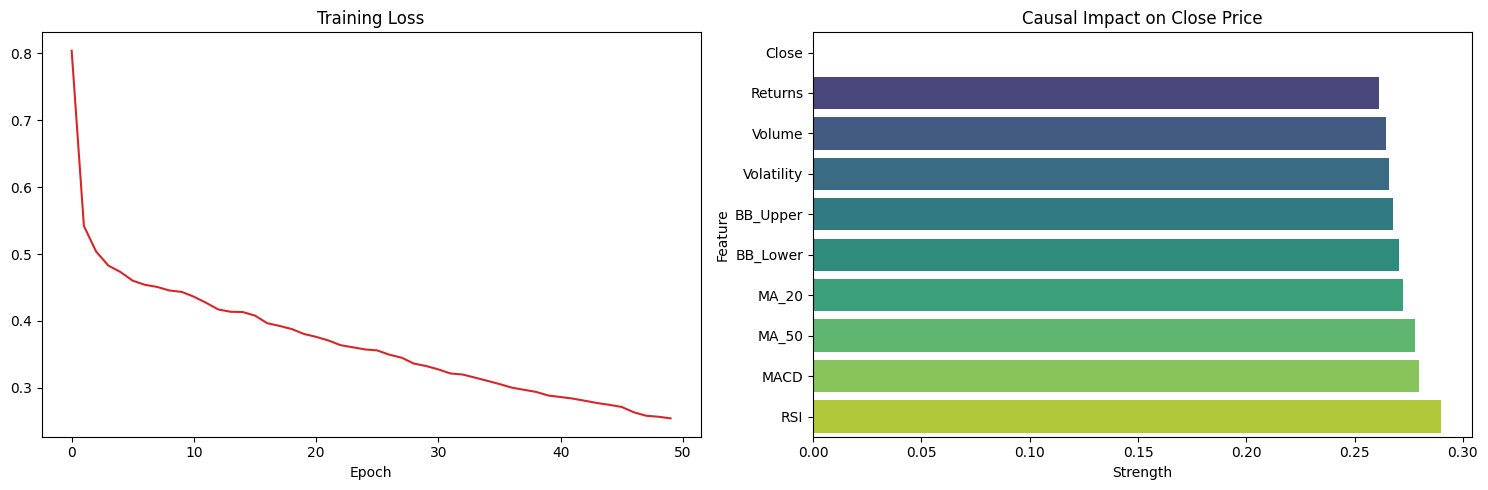

In [5]:
# 5) ANALYTICS & VISUALIZATION
def plot_results(model, history, features):
    model.eval()
    plt.figure(figsize=(15, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], color='tab:red')
    plt.title("Training Loss")
    plt.xlabel("Epoch")

    # Causal Strength on 'Close'
    plt.subplot(1, 2, 2)
    adj = model.causal_discovery.get_causal_adjacency().detach().cpu().numpy()
    close_idx = features.index('Close')
    strength = adj[:, close_idx]
    inf_df = pd.DataFrame({'Feature': features, 'Strength': strength}).sort_values('Strength')
    sns.barplot(data=inf_df, x='Strength', y='Feature', palette='viridis')
    plt.title("Causal Impact on Close Price")

    plt.tight_layout()
    plt.show()

plot_results(model, history, features)

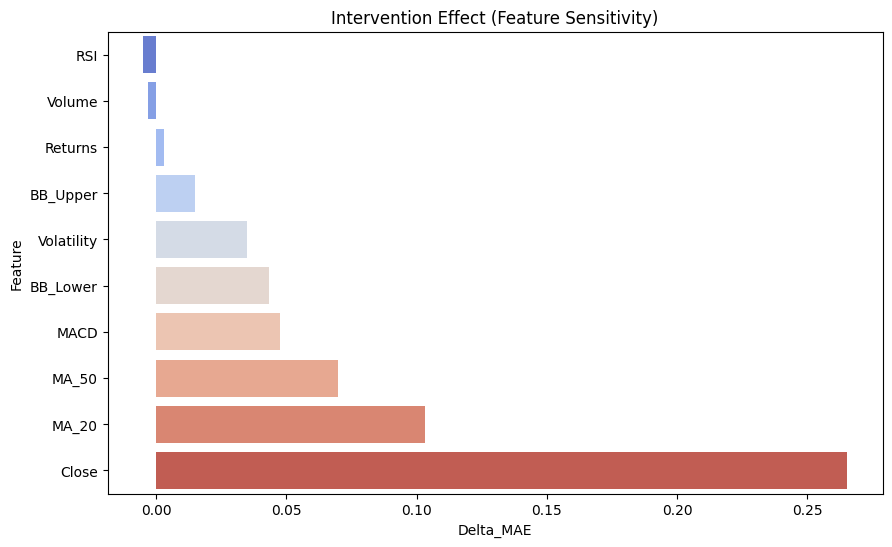

In [6]:
# 6) INTERVENTION STUDY
def run_intervention(model, test_loader, features):
    model.eval()
    effects = {}
    with torch.no_grad():
        # Baseline error
        base_err = []
        for xb, yb in test_loader:
            p, _, _ = model(xb.to(device))
            base_err.append(np.abs(p.cpu().numpy() - yb.numpy().reshape(-1,1)))
        base_mae = np.mean(np.concatenate(base_err))

        for i, f in enumerate(features):
            int_err = []
            for xb, yb in test_loader:
                xb_int = xb.clone()
                xb_int[:, :, i] = 0 # Can thiệp bằng cách triệt tiêu biến
                p, _, _ = model(xb_int.to(device))
                int_err.append(np.abs(p.cpu().numpy() - yb.numpy().reshape(-1,1)))
            effects[f] = np.mean(np.concatenate(int_err)) - base_mae

    eff_df = pd.DataFrame(list(effects.items()), columns=['Feature', 'Delta_MAE']).sort_values('Delta_MAE')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=eff_df, x='Delta_MAE', y='Feature', palette='coolwarm')
    plt.title("Intervention Effect (Feature Sensitivity)")
    plt.show()

run_intervention(model, test_loader, features)